In [1]:
!python --version

Python 3.7.6


In [2]:
import pandas as pd
import numpy as np
import re
import string
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import keras

Using TensorFlow backend.


In [3]:
df_hindi =  pd.read_excel (r'data/hindi_dataset.xlsx', sheet_name='Sheet1')
df_punjabi = pd.read_excel (r'data/punjabi_dataset.xlsx', sheet_name='Sheet1')
df_gujarati = pd.read_excel (r'data/gujarati_dataset.xlsx', sheet_name='Sheet1')

In [4]:
df_hindi.tail(5)

,sent_index,word,tag
157922,10925,फ्रांसीसी,O
157923,10925,भौतिक,I-ORG
157924,10925,विज्ञानी,I-PER
157925,10925,थे,O
157926,10925,।,O


In [5]:
df_punjabi['sent_index'] = df_punjabi['sent_index'].apply(lambda x : x + df_hindi.tail(5).values[0][0]+1)
df_gujarati ['sent_index'] = df_gujarati ['sent_index'].apply(lambda x : x + df_punjabi.tail(5).values[0][0]+1)

In [6]:
df_punjabi.tail()

,sent_index,word,tag
47886,13918,ਇੱਕ,O
47887,13918,ਸਿੱਖ,I-PER
47888,13918,ਰਾਸ਼ਟਰਵਾਦੀ,O
47889,13918,ਨੇਤਾ,O
47890,13918,ਸਨ,I-PER


In [7]:
df_gujarati.head()

,sent_index,word,tag
0,13919,ભારતીય,B-LOC
1,13919,ગણરાજ્ય,O
2,13919,એ,O
3,13919,અનેક,O
4,13919,સાંસ્કૃતિક,O


In [8]:
data = pd.concat([df_hindi,df_punjabi,df_gujarati])
data.sample(5)

,sent_index,word,tag
110781,7653,थे,O
37807,16670,રાજ્યમાં,I-LOC
141842,9763,अवस्थित,O
5613,14332,તુલનામાં,O
41214,16923,આવેલા,O


In [9]:
words = list(set(data["word"].values))
words.append("ENDPAD")
n_words = len(words); 
n_words

22922

In [10]:
tags = list(set(data["tag"].values))
n_tags = len(tags); n_tags

7

In [11]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sent_index").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
         try:
            s = self.grouped[int("{}".format(self.n_sent))]
            self.n_sent += 1
            return s
         except:
            return None

In [12]:
getter = SentenceGetter(data)

This is how the sentences in the dataset look like.

In [13]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['जापान', 'एशिया', 'महाद्वीप', 'में', 'स्थित', 'देश', 'है', '।']

The sentences are annotated with the BIO-schema and the labels look like this.

In [14]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['B-LOC', 'B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O']


In [15]:
tag_values = list(set(data["tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

# BERT

In [16]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig, AutoModel, AutoTokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


'1.5.0'

Here we fix some configurations. We will limit our sequence length to 75 tokens and we will use a batch size of 32 as suggested by the Bert paper. Note, that Bert supports sequences of up to 512 tokens.

In [17]:
MAX_LEN = 75
bs = 32

In [18]:
device = torch.device("cpu")
#n_gpu = torch.cuda.device_count()

In [19]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
# tokenizer = BertWordPieceTokenizer()

In [20]:
tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert')

In [21]:
### TESTING TOKENIZER – CLEAN LATER

# test_sentence = """"जापान, एशिया महाद्वीप में स्थित देश है।"""
test_sentence = """"ਸੰਯੁਕਤ ਰਾਜ ਅਮਰੀਕਾ ਅੰਗਰੇਜ਼ੀ ਅਤੇ ਆਮ ਬੋਲਚਾਲ"""

tokenized_sentence = tokenizer.encode(test_sentence)

input_ids = torch.tensor([tokenized_sentence])
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])

new_tokens, new_labels = [], []
for token in tokens:
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_tokens.append(token)
    
for token in new_tokens:
    print("{}".format(token))

[CLS]
▁"
ਸੰ
ਯੁਕਤ
▁ਰਾਜ
▁ਅਮਰੀਕਾ
▁ਅੰਗਰੇਜ
ੀ
▁ਅਤੇ
▁ਆਮ
▁ਬੋਲ
ਚਾਲ
[SEP]


In [22]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [23]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [24]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

Next, we cut and pad the token and label sequences to our desired length.

In [25]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [26]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

The Bert model supports something called attention_mask, which is similar to the masking in keras. So here we create the mask to ignore the padded elements in the sequences.

In [27]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [28]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

Since we’re operating in pytorch, we have to convert the dataset to torch tensors.

In [29]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

The last step is to define the dataloaders. We shuffle the data at training time with the RandomSampler and at test time we just pass them sequentially with the SequentialSampler.

In [30]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [31]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'3.4.0'

In [32]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

# model = AutoModel.from_pretrained('ai4bharat/indic-bert', 
#                                   num_labels=len(tag2idx),
#                                 output_attentions = False,
#                                 output_hidden_states = False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [33]:
model.to("cpu")

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [34]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


In [35]:
from transformers import get_linear_schedule_with_warmup

epochs = 8
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [36]:
from seqeval.metrics import f1_score, accuracy_score
from tqdm import tqdm, trange

In [37]:
f1_score = []
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []
model.resize_token_embeddings(len(tokenizer))
for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    f1_score.append([pred_tags, valid_tags])
    #print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Average train loss: 0.8878811604611375


Epoch:  12%|█▎        | 1/8 [49:47<5:48:32, 2987.50s/it]

Validation loss: 0.5665251535397989
Validation Accuracy: 0.8163609085884241

Average train loss: 0.4988289452611043


Epoch:  25%|██▌       | 2/8 [1:39:13<4:58:07, 2981.18s/it]

Validation loss: 0.3987862992065924
Validation Accuracy: 0.8681336035585503

Average train loss: 0.3486146709069949


Epoch:  38%|███▊      | 3/8 [2:29:19<4:09:02, 2988.48s/it]

Validation loss: 0.3074719743044288
Validation Accuracy: 0.9000078961914036

Average train loss: 0.26171636334610776


Epoch:  50%|█████     | 4/8 [3:19:43<3:19:56, 2999.02s/it]

Validation loss: 0.28114178335225143
Validation Accuracy: 0.907877766957071

Average train loss: 0.2049365611611933


Epoch:  62%|██████▎   | 5/8 [4:09:53<2:30:07, 3002.52s/it]

Validation loss: 0.24582659591127326
Validation Accuracy: 0.9233806227462954

Average train loss: 0.1682126925753017


Epoch:  75%|███████▌  | 6/8 [5:00:25<1:40:22, 3011.32s/it]

Validation loss: 0.2235633686736778
Validation Accuracy: 0.9321190745663674

Average train loss: 0.1439395232847265


Epoch:  88%|████████▊ | 7/8 [5:52:02<50:36, 3036.87s/it]  

Validation loss: 0.22042523269300107
Validation Accuracy: 0.9348301002816308

Average train loss: 0.1286254857529888


Epoch: 100%|██████████| 8/8 [6:41:23<00:00, 3010.46s/it]

Validation loss: 0.21663327252975217
Validation Accuracy: 0.9367515068565262



In [38]:
torch.save(model,'./Models/BERT_indictokenizer.h5')
torch.save(model.state_dict(), './Models/BERT_indictokenizer.pt')

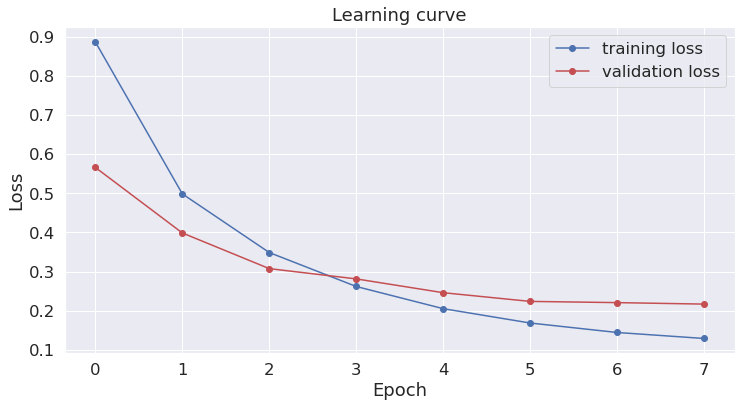

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [55]:
from sklearn.metrics import classification_report
predicted_tags_8 = f1_score[7][0] 
test_tags_8 = f1_score[7][1]

print((classification_report(predicted_tags_8,test_tags_8)))

              precision    recall  f1-score   support

       B-LOC       0.93      0.89      0.91      3133
       B-ORG       0.87      0.88      0.87      1435
       B-PER       0.74      0.72      0.73       966
       I-LOC       0.95      0.95      0.95      2712
       I-ORG       0.93      0.92      0.92      4721
       I-PER       0.91      0.89      0.90      2658
           O       0.95      0.96      0.96     22368

    accuracy                           0.94     37993
   macro avg       0.90      0.89      0.89     37993
weighted avg       0.94      0.94      0.94     37993



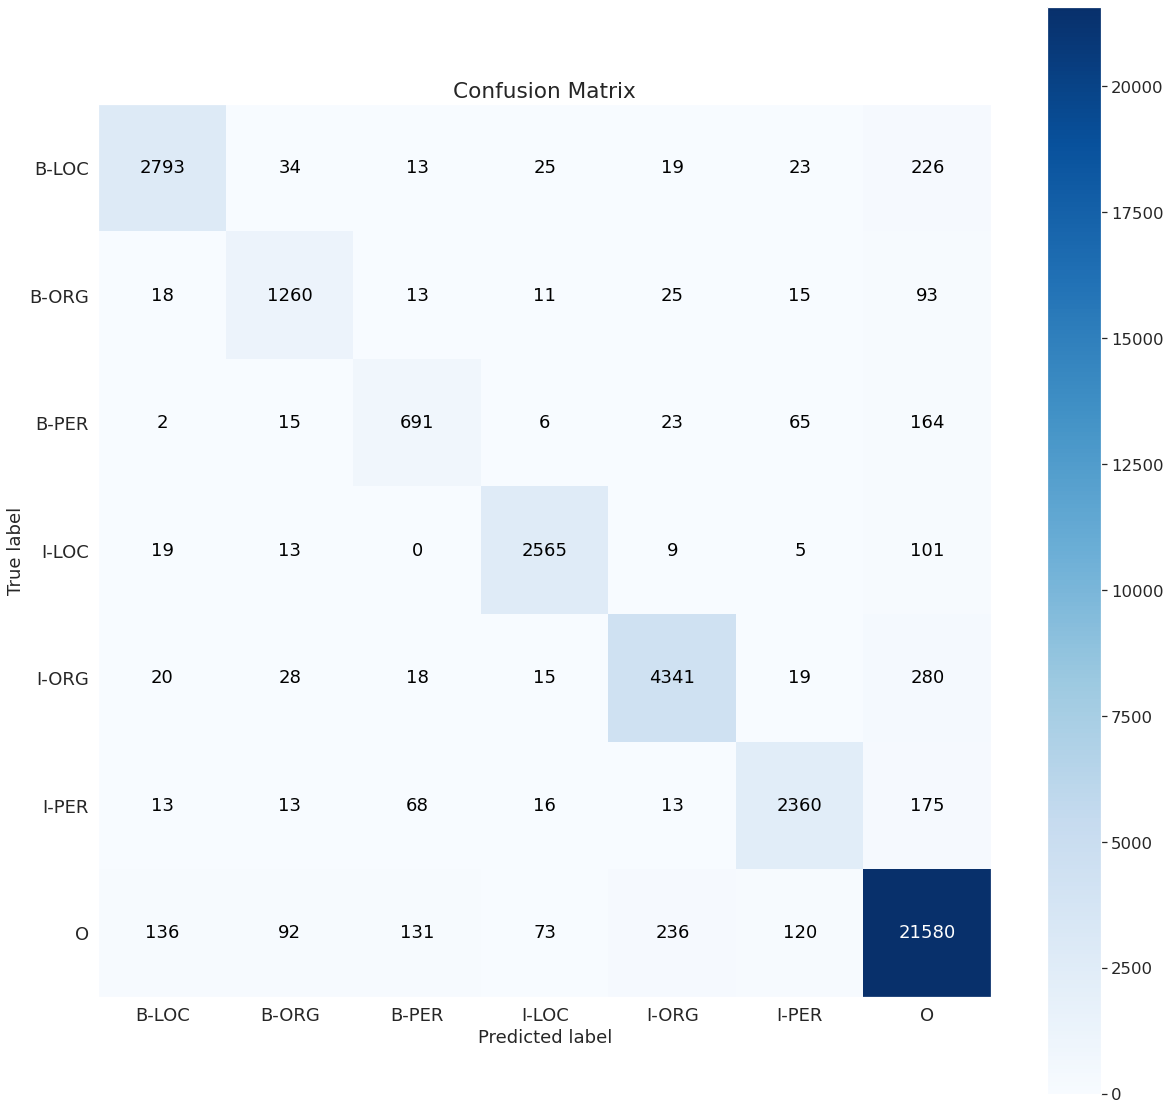

In [64]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(predicted_tags_8,test_tags_8,figsize=(20,20))
plt.show()

# Transfer Learning Test

In [43]:
def tranfer_learning_ner_model(test_sentence):
    tokenized_sentence = tokenizer.encode(test_sentence)
    
    input_ids = torch.tensor([tokenized_sentence])
    
    with torch.no_grad():
        output = model(input_ids)
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
    
    # join bpe split tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
    new_tokens, new_labels = [], []
    
    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(tag_values[label_idx])
            new_tokens.append(token)
            
    for token, label in zip(new_tokens, new_labels):
        print("{}\t{}".format(label, token))

In [45]:
test_sentence_hindi = """"जापान, एशिया महाद्वीप में स्थित देश है।"""
tranfer_learning_ner_model(test_sentence_hindi)

O	[CLS]
O	▁"
O	जा
O	पान
O	,
B-LOC	▁एशिया
I-LOC	▁महा
I-LOC	दव
I-LOC	ीप
O	▁में
O	▁स
O	थ
O	ित
O	▁देश
O	▁है
O	।
O	[SEP]


In [47]:
test_sentence_punjabi = """ਜਪਾਨ ਏਸ਼ੀਆ ਮਹਾਂਦੀਪ ਵਿੱਚ ਸਥਿਤ ਇੱਕ ਦੇਸ਼ ਹੈ."""
tranfer_learning_ner_model(test_sentence_punjabi)

O	[CLS]
B-LOC	▁ਜਪਾਨ
B-LOC	▁ਏ
B-LOC	ਸੀਆ
I-LOC	▁ਮਹਾਂ
I-LOC	ਦੀਪ
O	▁ਵਿੱਚ
O	▁ਸਥਿਤ
O	▁ਇੱਕ
I-LOC	▁ਦੇਸ
O	▁ਹੈ
O	.
O	[SEP]


In [48]:
test_sentence_gujarati = """જાપાન એશિયા ખંડમાં સ્થિત એક દેશ છે."""
tranfer_learning_ner_model(test_sentence_gujarati)

B-LOC	[CLS]
B-LOC	▁જાપાન
B-LOC	▁એશિયા
O	▁
O	ખંડમાં
O	▁સ
O	થ
O	િત
O	▁એક
O	▁દેશ
O	▁છે
O	.
O	[SEP]
